## Setting up the environment

In [1]:
# move to the project directory
import os
os.chdir("..")

from pathlib import Path
MOLECULES_FILE = 'molecules.json'
MOLECULES_DIR = Path('.', 'data', MOLECULES_FILE)

import pandas as pd
from pprint import pprint

# import the project
from quantum_simulation.drivers import molecule_loader

In [2]:
molecules = molecule_loader.load_molecule(MOLECULES_DIR)
pprint(molecules)

[MoleculeInfo(symbols=['H', 'H'],
              coords=[[0.0, 0.0, 0.0], [0.0, 0.0, 0.74]],
              multiplicity=1,
              charge=0,
              units=<DistanceUnit.ANGSTROM: 'Angstrom'>,
              masses=[1.008, 1.008]),
 MoleculeInfo(symbols=['O', 'H', 'H'],
              coords=[[0.0, 0.0, 0.0],
                      [0.0, 0.757, 0.586],
                      [0.0, -0.757, 0.586]],
              multiplicity=1,
              charge=0,
              units=<DistanceUnit.ANGSTROM: 'Angstrom'>,
              masses=[15.999, 1.008, 1.008])]


#### Visualization module

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from quantum_simulation.visual.molecule import MoleculePlotter

PosixPath('graphs/molecule_plots/molecule_HH.png')

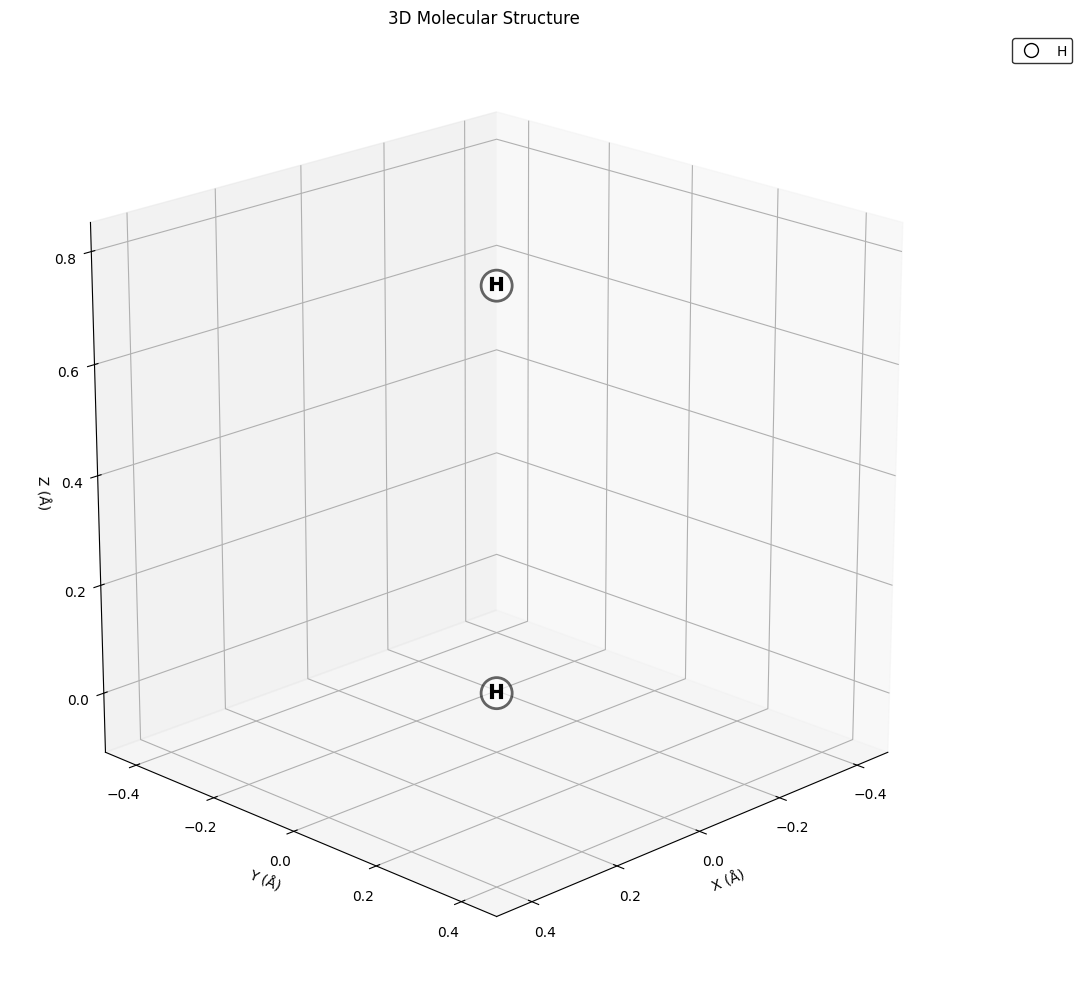

In [4]:
plotter = MoleculePlotter(figsize=(12, 10))
plotter.plot_molecule(molecules[0])

### QuantumCirciut information extraction

In [19]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
x = ParameterVector("x", 12)
circuit = QuantumCircuit(1)

features = {
    "width":circuit.num_qubits,
    "depth": circuit.depth(),
    "ancillas": circuit.num_ancillas,
    "clbits": circuit.num_clbits,
}

features

{'width': 1, 'depth': 0, 'ancillas': 0, 'clbits': 0}